# Tercer parcial: examen práctico 
### Larissa Rodríguez Millán 

In [63]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

### Obtener clases del dataset Brain Tumor, y mover imágenes acorde a su clasificación (tumor / no_tumor) para los datos de entrenamiento y validación

In [50]:
import os
import pandas as pd
import shutil

# Rutas base
dataset_path = r"C:\Users\laris\OneDrive\Documentos\LNC\Modeloscomputacionales\modelos_II\S03_datasets\Brain_tumor\Brain Tumor\Brain Tumor"
csv_path = os.path.join(dataset_path, "Brain Tumor.csv")

# Cargar etiquetas
df = pd.read_csv(csv_path)

# Carpetas base
train_dir = os.path.join(dataset_path, "TRAIN")
val_dir = os.path.join(dataset_path, "VAL")

# Crear subcarpetas si no existen
for folder in ["tumor", "no_tumor"]:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Carpeta donde están realmente las imágenes
all_images_dir = dataset_path  # <- cámbiala si están en otra subcarpeta

# Distribuir imágenes
not_found = []

for _, row in df.iterrows():
    image_name = row["Image"] + ".jpg"
    label = str(row["Class"])  # "1" o "0"
    
    src_path = os.path.join(all_images_dir, image_name)

    if not os.path.exists(src_path):
        not_found.append(image_name)
        continue

    # Separar TRAIN y VAL, por ejemplo 80/20
    if hash(image_name) % 5 == 0:
        dest_folder = os.path.join(val_dir, "tumor" if label == "1" else "no_tumor")
    else:
        dest_folder = os.path.join(train_dir, "tumor" if label == "1" else "no_tumor")

    shutil.copy(src_path, os.path.join(dest_folder, image_name))

print(f"✅ Imágenes organizadas. No encontradas: {len(not_found)}")

if not_found:
    print("⚠️ Estas imágenes no se encontraron:")
    print(not_found[:10])  # muestra solo las primeras 10


✅ Imágenes organizadas. No encontradas: 0


In [51]:
df = pd.read_csv(csv_path)
df

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Image3758,0,21.234512,1208.850174,34.768523,0.063774,2.082079,4.647310,158.437600,0.220666,0.048693,0.487131,5.211739,0.950972,7.458341e-155
3758,Image3759,0,20.435349,1227.151440,35.030721,0.066763,2.144625,4.882034,161.158675,0.225931,0.051045,0.502712,5.083126,0.952749,7.458341e-155
3759,Image3760,0,18.011520,1151.582765,33.934978,0.068396,2.308349,5.579498,167.130118,0.228930,0.052409,0.492269,5.103700,0.952181,7.458341e-155
3760,Image3761,0,13.330429,945.732779,30.752769,0.087872,2.732822,7.757570,223.812932,0.261527,0.068397,0.480064,6.439784,0.940898,7.458341e-155


In [53]:
import os

def contar_imagenes(carpeta):
    return len([nombre for nombre in os.listdir(carpeta) if nombre.endswith(".jpg")])

print("📊 TRAIN")
print(f"Tumor: {contar_imagenes(tumor_dir)} imágenes")
print(f"No Tumor: {contar_imagenes(no_tumor_dir)} imágenes")

print("\n📊 VALIDACIÓN")
print(f"Tumor: {contar_imagenes(tumor_val_dir)} imágenes")
print(f"No Tumor: {contar_imagenes(no_tumor_val_dir)} imágenes")


📊 TRAIN
Tumor: 1585 imágenes
No Tumor: 1944 imágenes

📊 VALIDACIÓN
Tumor: 498 imágenes
No Tumor: 684 imágenes


### CNN del modelo 

In [55]:
train_dir = r"C:\Users\laris\OneDrive\Documentos\LNC\Modeloscomputacionales\modelos_II\S03_datasets\Brain_tumor\Brain Tumor\Brain Tumor\TRAIN"
val_dir   = r"C:\Users\laris\OneDrive\Documentos\LNC\Modeloscomputacionales\modelos_II\S03_datasets\Brain_tumor\Brain Tumor\Brain Tumor\VAL"


In [56]:
img_size = (150, 150)
batch_size = 32

# Aumentación solo para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Carga de imágenes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)


Found 3529 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [57]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # salida binaria
])


In [58]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20


111/111 [==============================] - 128s 1s/step - loss: 0.4942 - accuracy: 0.7665 - val_loss: 0.3751 - val_accuracy: 0.8460
Epoch 2/20
111/111 [==============================] - 78s 704ms/step - loss: 0.4039 - accuracy: 0.8243 - val_loss: 0.3730 - val_accuracy: 0.8562
Epoch 3/20
111/111 [==============================] - 77s 693ms/step - loss: 0.3446 - accuracy: 0.8552 - val_loss: 0.4354 - val_accuracy: 0.8350
Epoch 4/20
111/111 [==============================] - 77s 694ms/step - loss: 0.3165 - accuracy: 0.8631 - val_loss: 0.4673 - val_accuracy: 0.8257
Epoch 5/20
111/111 [==============================] - 76s 681ms/step - loss: 0.3145 - accuracy: 0.8657 - val_loss: 0.2924 - val_accuracy: 0.8866
Epoch 6/20
111/111 [==============================] - 79s 706ms/step - loss: 0.3125 - accuracy: 0.8668 - val_loss: 0.4694 - val_accuracy: 0.8181
Epoch 7/20
111/111 [==============================] - 76s 684ms/step - loss: 0.2997 - accuracy: 0.8728 - val_loss: 0.4173 - val_ac

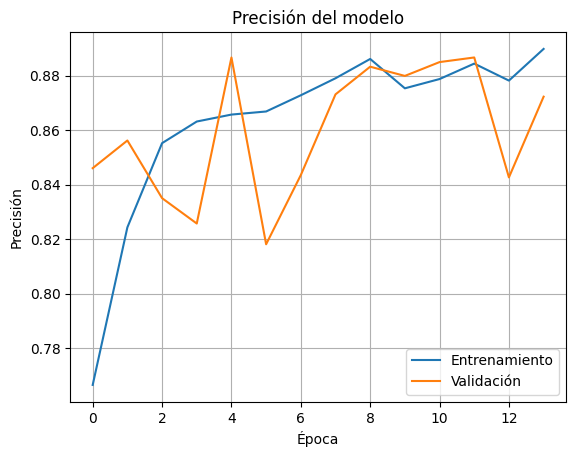

In [64]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

### Sacar medidas para las diferentes épocas y capas. 

In [69]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE   = (128, 128)
BATCH_SIZE  = 32

aug_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

plain_val  = ImageDataGenerator(rescale=1./255)

train_generator = aug_train.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = plain_val.flow_from_directory(
    val_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

def cnn_a():
    net = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.50),
        Dense(1, activation='sigmoid')
    ])
    return net

def cnn_b():
    net = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.40),
        Dense(1, activation='sigmoid')
    ])
    return net

def cnn_c():
    net = Sequential([
        Conv2D(64,  (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.35),
        Dense(1, activation='sigmoid')
    ])
    return net

model_pack   = [cnn_a(), cnn_b(), cnn_c()]
epochs_pack  = [15, 20, 30]
log_metrics  = []

early = EarlyStopping(monitor='val_loss',
                      patience=5,
                      restore_best_weights=True,
                      verbose=1)

for net, n_epochs in zip(model_pack, epochs_pack):

    net.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    h = net.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs,
        callbacks=[early],
        verbose=1
    )

    train_acc = h.history['accuracy'][-1]
    val_acc   = h.history['val_accuracy'][-1]

    log_metrics.append({
        'épocas': n_epochs,
        'acc_entrenamiento': round(train_acc, 4),
        'acc_validación':   round(val_acc,   4)
    })

for fila in log_metrics:
    print(f"Ep:{fila['épocas']:>2} | "
          f"train_acc={fila['acc_entrenamiento']:.4f} | "
          f"val_acc={fila['acc_validación']:.4f}")


Found 3529 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.
Epoch 1/15
111/111 [==============================] - 67s 585ms/step - loss: 0.5117 - accuracy: 0.7659 - val_loss: 0.4127 - val_accuracy: 0.8223
Epoch 2/15
111/111 [==============================] - 56s 500ms/step - loss: 0.3937 - accuracy: 0.8325 - val_loss: 0.3670 - val_accuracy: 0.8519
Epoch 3/15
111/111 [==============================] - 56s 502ms/step - loss: 0.3452 - accuracy: 0.8515 - val_loss: 0.4482 - val_accuracy: 0.8190
Epoch 4/15
111/111 [==============================] - 56s 508ms/step - loss: 0.3197 - accuracy: 0.8657 - val_loss: 0.5352 - val_accuracy: 0.8003
Epoch 5/15
111/111 [==============================] - 52s 470ms/step - loss: 0.3220 - accuracy: 0.8603 - val_loss: 0.3945 - val_accuracy: 0.8401
Epoch 6/15
111/111 [==============================] - 53s 480ms/step - loss: 0.2934 - accuracy: 0.8787 - val_loss: 0.2780 - val_accuracy: 0.8841
Epoch 7/15
111/111 [==========================

In [3]:
print(log_metrics[:3])


NameError: name 'log_metrics' is not defined

In [1]:

epochs = [r['épocas'] for r in log_metrics]
train_acc = [r['acc_entrenamiento'] for r in log_metrics]
val_acc = [r['acc_validación'] for r in log_metrics]

plt.plot(epochs, train_acc, label="Entrenamiento", marker="o")
plt.plot(epochs, val_acc, label="Validación", marker="o")
plt.xlabel("Épocas")
plt.ylabel("Precisión (Accuracy)")
plt.title("Comparación de Accuracy con Diferentes Épocas")
plt.legend()

texto = "Se observa una mejora progresiva en la precisión de\nentrenamiento y validación con el aumento de épocas."
plt.gcf().text(0.5, 0.02, texto, fontsize=10, ha='center')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'log_metrics' is not defined